In [1]:
animal = 'AE2'
unit = '001'
trials = ['013', '015']

zoom = 2

file_path = 'D:\\2P_data\\F\\%s\\u%s_%s\\1_2\\F_%s_u%s_%s_plane1_proc.mat' % (animal, unit, trials[0], animal, unit, trials[0])
analyzer_paths = []
for trial_ in trials:
    analyzer_paths.append('F:\\NHP\\AE2\\AnalyzerFiles\\%s\\%s_u%s_%s.analyzer' % (animal, animal, unit, trial_))
plot = 'n'
plot_gaussian_fit = 'n'

In [2]:
import pandas as pd
import scipy.io as sio
import functions

F = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)['dat']
params = []
trial_num_list = []
for i, analyzer_path_ in enumerate(analyzer_paths):
    params.append(functions.analyzer_params(analyzer_path_))
    trial_num_, stim_time = functions.analyzer_pg_conds(analyzer_path_)
    if 'colormod' not in trial_num_.columns:
        trial_num_['colormod'] = params[i]['colormod']
    trial_num_list.append(trial_num_)
trial_num = pd.concat(trial_num_list, ignore_index=True)
trial_num['direction'] = trial_num.ori
trial_num.ori[(trial_num.ori >= 180)] = trial_num.ori[(trial_num.ori >= 180)] - 180

In [22]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

mean_image = F.mimg[:, :, 1]
color_mask = np.zeros(mean_image.shape)
ori_mask = np.zeros(mean_image.shape)
ori_mask[:, :] = -1
ori_mask_ach = np.zeros(mean_image.shape)
ori_mask_ach[:, :] = -1
cell_df = pd.DataFrame(columns=['expt', 'cell', 'x_col', 'y_col', 'x_ach', 'y_ach', 'color_pref', 'max_color_response', 'csi', 'osi_color', 'osi_ach', 
                                'ori_pref_color', 'ori_pref_ach', 'r_pref_color', 'r_pref_ach', 'r_min_color', 'r_min_ach',
                                'p_osi_color', 'p_osi_ach', 'p_color'])
cs_stim_df = pd.DataFrame()

color_hex = ['#af1600', '#8a4600', '#5a5d01', '#2a6600', '#006a00', '#006931', '#006464', '#0058b6', '#002DFF', '#6a2ade', '#97209b', '#aa1c50']


def get_grouped_max(cell_F_stim, sort_param, max_params):
    idx = pd.IndexSlice
    grouped = cell_F_stim.groupby(sort_param + max_params).mean()['Mean']
    max_values = []
    
    for param in max_params: 
        max_values.append(grouped.groupby(param).mean().idxmax())
    grouped_max = None
    if len(max_params) == 1:
        grouped_max = grouped.loc[idx[:, max_values[0]]]
    elif len(max_params) == 2:
        grouped_max = grouped.loc[idx[:, max_values[0], max_values[1]]]
    
    return grouped_max


def osi(cell_F_stim, sort_param, max_params):
    grouped_max = get_grouped_max(cell_F_stim, sort_param, max_params)
        
    r_pref = grouped_max.max()
    r_min = grouped_max.min()
    ori_pref = grouped_max.idxmax()
    
    if ori_pref < 90:
        ori_orth = ori_pref + 90
    else:
        ori_orth = ori_pref - 90
    r_orth = grouped_max.loc[ori_orth]
    cell_osi = (r_pref - r_orth) / r_pref
    return cell_osi, ori_pref, r_pref, r_min


def anova_list(cell_F_stim, sort_param):
        list_F_stim = [cell_F_stim[cell_F_stim[sort_param] == p_param]['Mean'] for p_param in np.unique(cell_F_stim[sort_param].values)]
        F_stat, p = sp.stats.f_oneway(*list_F_stim)
        return p


for i, cell in enumerate(F.stat):
    if cell.iscell == 1:
        scans = int(np.concatenate(F.Fcell, axis=1).shape[1] / trial_num.shape[0])
        t = np.linspace(stim_time[0] * -1, stim_time.sum() - stim_time[1], scans)
        cell_F = pd.DataFrame(np.reshape(np.concatenate(F.Fcell, axis=1)[i, :], (int(np.concatenate(F.Fcell, axis=1).shape[1] / scans), scans)))
        cell_F.insert(0, 'Orientation', trial_num.ori)
        cell_F.insert(1, 'Direction', trial_num.direction)
        cell_F.insert(2, 'Spatial Frequency', trial_num.s_freq)
        cell_F.insert(3, 'Color', trial_num.colormod)
        cell_F.insert(4, 'Baseline',
                      np.reshape(np.concatenate(F.Fcell, axis=1)[i, :], (int(np.concatenate(F.Fcell, axis=1).shape[1] / scans), scans))
                      [:, 0:int(np.floor(scans * stim_time[0] / stim_time.sum())) - 1].mean(axis=1))
        
        start_sample = int(np.ceil(scans * (stim_time[0] + 0.5) / stim_time.sum()))
        end_sample = int(scans - np.ceil(scans * (stim_time[1]) / stim_time.sum()))
        
        cell_F.iloc[:, -scans:] = cell_F.iloc[:, -scans:].subtract(cell_F['Baseline'], axis=0).divide(cell_F['Baseline'],
                                                                                                  axis=0)
        
        cell_F_stim = pd.DataFrame(cell_F.iloc[:, -(scans-start_sample):-(scans-end_sample)].mean(axis=1), columns=['Mean'])
        cell_F_stim.insert(0, 'Orientation', trial_num.ori)
        cell_F_stim.insert(1, 'Direction', trial_num.direction)
        cell_F_stim.insert(2, 'Spatial Frequency', trial_num.s_freq)
        cell_F_stim.insert(3, 'Color', trial_num.colormod)
        
        cell_F_stim_ach = cell_F_stim[cell_F_stim.Color == 1]        
        cell_F_stim_color = cell_F_stim[cell_F_stim.Color != 1]
        
        max_color_response = cell_F_stim_color.groupby('Color').mean()['Mean'].max()
        max_color = cell_F_stim_color.groupby('Color').mean()['Mean'].idxmax()
        max_sf_color = cell_F_stim_color.groupby('Spatial Frequency').mean()['Mean'].idxmax()
        max_ori_color = cell_F_stim_color.groupby('Orientation').mean()['Mean'].idxmax()
        max_dir_color = cell_F_stim_color.groupby('Direction').mean()['Mean'].idxmax()
        
        max_sf_response = cell_F_stim.groupby('Spatial Frequency').mean()['Mean'].max()
        max_sf = cell_F_stim.groupby('Spatial Frequency').mean()['Mean'].idxmax()
        
        cell_F_stim_dir_color = cell_F_stim_color[(cell_F_stim_color['Color'] == max_color) & (cell_F_stim_color['Spatial Frequency'] == max_sf_color)]
        
        # Calculate Color Information
        if max_ori_color < 90:
            ori_orth_color = max_ori_color + 90
        else:
            ori_orth_color = max_ori_color - 90
        
        r_pref_color = cell_F_stim_dir_color.groupby('Orientation').mean()['Mean'].max()
        r_orth_color = cell_F_stim_dir_color.groupby('Orientation').mean().loc[ori_orth_color]['Mean']
        
        osi_color = (r_pref_color - r_orth_color) / r_pref_color
        
        colors = np.unique(cell_F_stim_color.Color.values)
        list_F_stim_color = [cell_F_stim_dir_color[cell_F_stim['Color'] == color]['Mean'] for color in colors]
        F_value, p_color = sp.stats.f_oneway(*list_F_stim_color)
        
        oris = np.unique(trial_num.ori.values)
        list_F_stim_color_ori = [cell_F_stim_color[cell_F_stim['Orientation'] == ori]['Mean'] for ori in oris]
        F_value, p_osi_color = sp.stats.f_oneway(*list_F_stim_color_ori)
        
        # Calculate OSI and save into DataFrame
        x_med, y_med = cell.med
        osi_ach, ori_pref_ach, r_pref_ach, r_min_ach = osi(cell_F_stim_ach[cell_F_stim_ach['Spatial Frequency'] == max_sf], 
                                                           ['Orientation'], ['Spatial Frequency'])
        # osi_color, ori_pref_color, r_pref_color, r_min_color = osi(cell_F_stim[cell_F_stim.Color == max_color], 
        #                                                            ['Orientation'], ['Spatial Frequency', 'Color'])
                
        p_osi_ach = anova_list(cell_F_stim_ach[cell_F_stim_ach['Spatial Frequency'] == max_sf], 'Orientation')
        # p_osi_color = anova_list(cell_F_stim_color[cell_F_stim_color.Color == max_color], 'Orientation')
        # p_color = anova_list(cell_F_stim_color, 'Color')
        
        if max_color < 16:
            ortho_color = max_color + 6
        else:
            ortho_color = max_color - 6
        ortho_response = cell_F_stim_color.groupby('Color').mean()['Mean'][ortho_color]
        color_si = (max_color_response - ortho_response) / max_color_response
        
        cell_df.loc[i] = [analyzer_paths[0][-17:-9], i, x_med, y_med, x_med, y_med, max_color, max_color_response, color_si, osi_color, osi_ach,
                          max_ori_color, ori_pref_ach, r_pref_color, r_pref_ach, r_pref_color, r_min_ach, p_osi_color, p_osi_ach, p_color]
        
        if p_color < 0.001:
            if max_color_response > 0:
                if color_si > 0:
                    color_mask[(cell.ypix - 1), (cell.xpix - 1)] = max_color
                    cs_stim_df[i] = cell_F_stim.groupby('Color').mean()['Mean'].drop(1)
                    if plot == 'y':
                        plt.ioff()
                        fig, ax = plt.subplots()
                        ax.scatter(cell_F_stim.groupby('Color').mean()['Mean'].drop(1).index.values, cell_F_stim.groupby('Color').mean()['Mean'].drop(1).values, color=color_hex, s=100, zorder=2)
                        ax.fill_between(cell_F_stim.groupby('Color').mean()['Mean'].drop(1).index.values, 
                                        cell_F_stim.groupby('Color').mean()['Mean'].drop(1) - cell_F_stim.groupby('Color').sem()['Mean'].drop(1),
                                        cell_F_stim.groupby('Color').mean()['Mean'].drop(1) + cell_F_stim.groupby('Color').sem()['Mean'].drop(1),
                                        alpha=0.5, color='#808080', zorder=1)
                        ax.xaxis.set_ticks([])
                        ax.set_ylabel(r'Response ($\Delta F/F$)')
                        plt.savefig('D:/nhp_cells/cell%d.pdf' % i, format='pdf')
                        plt.close()
                        
        if p_osi_color < 0.01:
            if r_pref_color > 0.02:
                if osi_color > 0.3:
                    ori_mask[(cell.ypix - 1), (cell.xpix - 1)] = max_ori_color
                    
        if p_osi_ach < 0.01:
            if r_pref_ach > 0:
                if osi_ach > 0:
                    ori_mask_ach[(cell.ypix - 1), (cell.xpix - 1)] = ori_pref_ach

cell_df.to_csv('D:/nhp_cells/%s_%s_all_pref_df.csv' % (animal, analyzer_paths[0][-17:-9]))
cs_stim_df.to_csv('D:/nhp_cells/%s_cs_stim_df.csv' % analyzer_paths[0][-17:-9])

C:\Users\anupam\Miniconda3\envs\color_vision\lib\site-packages\ipykernel_launcher.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\anupam\Miniconda3\envs\color_vision\lib\site-packages\scipy\stats\stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))
C:\Users\anupam\Miniconda3\envs\color_vision\lib\site-packages\ipykernel_launcher.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [23]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import ColorConverter
colors = ['#af1600', '#8a4600', '#5a5d01', '#2a6600', '#006a00', '#006931', '#006464', '#0058b6', '#002DFF', '#6a2ade', '#97209b', '#aa1c50']
cmap = ListedColormap(colors, 'indexed')
cmap.set_under(ColorConverter.to_rgba('white', alpha=0))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mean_image, cmap='gray', alpha=0.8)
im = ax.imshow(color_mask, cmap=cmap, vmin=10)
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.axis('off')
plt.savefig('D:/nhp_cells/%s_color_map.pdf' % analyzer_paths[0][-17:-9], format='pdf', bbox_inches='tight')
plt.show()
plt.close()
np.save('D:/nhp_cells/%s_color_map.npy' % analyzer_paths[0][-17:-9], color_mask)

cmap_ori = plt.cm.get_cmap('plasma')
cmap_ori.set_under(ColorConverter.to_rgba('white', alpha=0))
# fig, ax = plt.subplots(figsize=(7, 7))
# ax.imshow(mean_image, cmap='gray', alpha=0.8)
# im = ax.imshow(ori_mask, cmap=cmap_ori, vmin=0)
# cb = fig.colorbar(im)
# cb.set_ticks([])
# cb.set_label('Preferred Color')
# plt.axis('off')
# plt.savefig('D:/nhp_cells/%s_ori_map.pdf' % analyzer_paths[0][-17:-9], format='pdf', bbox_inches='tight')
# plt.show()
# plt.close()
# np.save('D:/nhp_cells/%s_ori_map.npy' % analyzer_paths[0][-17:-9], ori_mask)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mean_image, cmap='gray', alpha=0.8)
im = ax.imshow(ori_mask_ach, cmap=cmap_ori, vmin=0)
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.axis('off')
plt.savefig('D:/nhp_cells/%s_ori_map_ach.pdf' % analyzer_paths[0][-17:-9], format='pdf', bbox_inches='tight')
plt.show()
plt.close()
np.save('D:/nhp_cells/%s_ori_map_ach.npy' % analyzer_paths[0][-17:-9], ori_mask_ach)

In [21]:
cmap_black = ListedColormap(['#000000'], 'indexed')
cmap_black.set_under(ColorConverter.to_rgba('white', alpha=0))

cmap_red = ListedColormap(['#ff0000'], 'indexed')
cmap_red.set_under(ColorConverter.to_rgba('white', alpha=0))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mean_image, cmap='gray', alpha=0.8)
im_ori = ax.imshow(ori_mask_ach, cmap=cmap_black, vmin=0, alpha=0.5, origin='lower', aspect='auto')
im_color = ax.imshow(color_mask, cmap=cmap_white, vmin=10, alpha=0.5, origin='lower', aspect='auto')
plt.axis('off')
plt.savefig('D:/nhp_cells/%s_overlay.pdf' % analyzer_paths[0][-17:-9], format='pdf', bbox_inches='tight')
plt.show()
plt.close()

NameError: name 'cmap_white' is not defined

In [74]:
# Plot orientation selective cells
v_response_cells = cell_df[(cell_df.r_pref_ach > 0.03)]
ori_cells = cell_df[(cell_df.p_osi_ach < 0.01) & (cell_df.osi_ach > 0.3) & (cell_df.r_pref_ach > 0.02)]
color_cells = cell_df[(cell_df.csi > 0.7) & (cell_df.max_color_response > 0.05) & (cell_df.p_color < 0.001)]
fig, ax = plt.subplots()
im = ax.scatter(ori_cells.x, ori_cells.y, s=30, c=ori_cells.ori_pref_ach, 
                cmap='plasma', edgecolors='k', vmin=0, vmax=135)
plt.show()
plt.close()

In [ ]:
import glob
color_map_files = glob.glob('D:\\nhp_cells\\*color_map.npy')
fig, ax = plt.subplots()
for file in color_map_files:
    color_map = np.load(file)
    ax.imshow(color_map, cmap=cmap, vmin=10, vmax=21)
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.title('Color Tuning Map')
plt.savefig('D:/nhp_cells/color_map_all.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [143]:
import glob

overlay_trials = ['013', '020']
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
for trial in overlay_trials:
    ori_map = np.load(glob.glob('D:\\nhp_cells\\*%s_ori_map_ach.npy' % trial)[0])
    color_map = np.load(glob.glob('D:\\nhp_cells\\*%s_color_map.npy' % trial)[0])
    ax.imshow(color_map, cmap=cmap_red, vmin=10, alpha=0.5)
    ax.imshow(ori_map, cmap=cmap_black, vmin=0, alpha=0.5)
    ax2.imshow(color_map, cmap=cmap, vmin=10, vmax=21)
    ax3.imshow(ori_map, cmap=cmap_ori, vmin=0)
ax.set_xticks([])
ax.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

ax.set_title('Orientation and Color Tuned Cells')
fig.savefig('D:/nhp_cells/overlay_map_all.pdf', format='pdf', bbox_inches='tight')

ax2.set_title('Color Map')
fig.savefig('D:/nhp_cells/color_map_all.pdf', format='pdf', bbox_inches='tight')

ax3.set_title('Orientation Map')
fig.savefig('D:/nhp_cells/ori_map_all.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [160]:
cs_stim_df_norm = (cs_stim_df - cs_stim_df.mean()) / (cs_stim_df.max() - cs_stim_df.min())
cs_stim_corr = cs_stim_df_norm.corr().where(np.triu(np.ones(cs_stim_df_norm.corr().shape)).astype(np.bool) == False)
# cs_stim_corr = cs_stim_df.corr().where(np.triu(np.ones(cs_stim_df.corr().shape)).astype(np.bool) == False)
cs_stim_corr = cs_stim_corr.stack().reset_index()
cs_stim_corr.columns = ['cell_1', 'cell_2', 'corr_coeff']


def distance(x1, x2, y1, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x1 = cell_df.loc[cs_stim_corr.cell_1].x.as_matrix().astype(float)
y1 = cell_df.loc[cs_stim_corr.cell_1].y.as_matrix().astype(float)
x2 = cell_df.loc[cs_stim_corr.cell_2].x.as_matrix().astype(float)
y2 = cell_df.loc[cs_stim_corr.cell_2].y.as_matrix().astype(float)
cs_stim_corr['distance'] = distance(x1, x2, y1, y2)

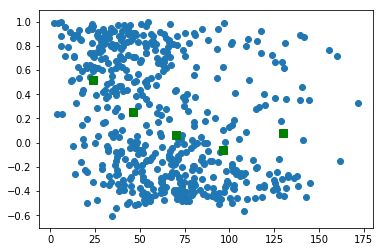

In [161]:
from scipy.cluster.vq import kmeans, vq
kmean_data = cs_stim_corr[['distance', 'corr_coeff']]
centroids, _ = kmeans(kmean_data, 5)
idx, _ = vq(kmean_data, centroids)

fig, ax = plt.subplots()
ax.scatter(cs_stim_corr.distance, cs_stim_corr.corr_coeff)
ax.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=8)
plt.show()

In [136]:
import ntpath
import random
color_pref_df_files = glob.glob('D:\\nhp_cells\\*color_pref_df.csv')
cs_stim_df_files = glob.glob('D:\\nhp_cells\\*cs_stim_df.csv')
cs_stim_corr_all = pd.DataFrame(columns=['cell_1', 'cell_2', 'corr_coeff', 'distance', 'analyzer'])
cs_stim_corr_shuff_all = pd.DataFrame(columns=['cell_1', 'cell_2', 'corr_coeff', 'distance', 'analyzer'])

umperpixel = 1.66

for i, file in enumerate(color_pref_df_files):
    color_pref_ = pd.read_csv(file, index_col=0)
    cs_stim_file = cs_stim_df_files[i]
    cs_stim_ = pd.read_csv(cs_stim_df_files[i], index_col=0)
    
    cs_stim_shuff_ = cs_stim_.copy().as_matrix().T
    np.random.shuffle(cs_stim_shuff_)
    cs_stim_shuff_ = cs_stim_shuff_.T
    cs_stim_shuff_ = pd.DataFrame(cs_stim_shuff_, columns=cs_stim_.columns)
    # cs_stim_shuff_.columns = random.shuffle(list(cs_stim_shuff_))
    
    cs_stim_df_norm = (cs_stim_ - cs_stim_.mean()) / (cs_stim_.max() - cs_stim_.min())
    cs_stim_corr = cs_stim_df_norm.corr().where(np.triu(np.ones(cs_stim_df_norm.corr().shape)).astype(np.bool) == False)
    # cs_stim_corr = cs_stim_df.corr().where(np.triu(np.ones(cs_stim_df.corr().shape)).astype(np.bool) == False)
    cs_stim_corr = cs_stim_corr.stack().reset_index()
    cs_stim_corr.columns = ['cell_1', 'cell_2', 'corr_coeff']
    
    cs_stim_shuff_df_norm = (cs_stim_shuff_ - cs_stim_shuff_.mean()) / (cs_stim_shuff_.max() - cs_stim_shuff_.min())
    cs_stim_corr_shuff = cs_stim_shuff_df_norm.corr().where(np.triu(np.ones(cs_stim_shuff_df_norm.corr().shape)).astype(np.bool) == False)
    cs_stim_corr_shuff = cs_stim_corr_shuff.stack().reset_index()
    cs_stim_corr_shuff.columns = ['cell_1', 'cell_2', 'corr_coeff']
    
        
    def distance(x1, x2, y1, y2):
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    def cs_stim_distance(color_pref_, cs_stim_corr, file):
        x1 = color_pref_.loc[cs_stim_corr.cell_1.as_matrix().astype(int)].x.as_matrix().astype(float)
        y1 = color_pref_.loc[cs_stim_corr.cell_1.as_matrix().astype(int)].y.as_matrix().astype(float)
        x2 = color_pref_.loc[cs_stim_corr.cell_2.as_matrix().astype(int)].x.as_matrix().astype(float)
        y2 = color_pref_.loc[cs_stim_corr.cell_2.as_matrix().astype(int)].y.as_matrix().astype(float)
        cs_stim_corr['distance'] = distance(x1, x2, y1, y2) * umperpixel
        cs_stim_corr['analyzer'] = ntpath.basename(file)[0:8]
        return cs_stim_corr
    
    
    cs_stim_corr = cs_stim_distance(color_pref_, cs_stim_corr, file)
    cs_stim_corr_shuff = cs_stim_distance(color_pref_, cs_stim_corr_shuff, file)
        
    cs_stim_corr_all = cs_stim_corr_all.append(cs_stim_corr)
    cs_stim_corr_shuff_all = cs_stim_corr_shuff_all.append(cs_stim_corr_shuff)
    
cs_stim_corr_cut = cs_stim_corr_all[cs_stim_corr_all.distance < 100]
cs_stim_corr_shuff_cut = cs_stim_corr_shuff_all[cs_stim_corr_shuff_all.distance < 100]
    
from scipy.cluster.vq import kmeans, vq
kmean_data = cs_stim_corr_cut[['distance', 'corr_coeff']]
num_clusters = 10
centroids, _ = kmeans(kmean_data, num_clusters)
idx, _ = vq(kmean_data, centroids)

kmean_data_shuff = cs_stim_corr_shuff_cut[['distance', 'corr_coeff']]
centroids_shuff, _ = kmeans(kmean_data_shuff, num_clusters)
idx_shuff, _ = vq(kmean_data_shuff, centroids_shuff)

fig, ax = plt.subplots()
for i in range(num_clusters):
    ax.scatter(kmean_data.distance.iloc[idx==i], kmean_data.corr_coeff.iloc[idx==i], marker='o', color='0.8', label=None)
ax.plot(centroids[:, 0], centroids[:, 1], marker='s', color='k', markersize=8, linestyle='None', label='Average')
ax.plot(centroids_shuff[:, 0], centroids_shuff[:, 1], marker='s', color='0.5', markersize=8, linestyle='None', label='Average (shuffled)')
ax.set_xlabel('Distance (um)')
ax.set_ylabel('Correlation Coefficient')
plt.legend()
plt.savefig('D:/nhp_cells/distance_corr.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [37]:
import glob
allFiles = glob.glob('D:/nhp_cells/*color_pref_df.csv')
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, index_col=None, header=0)
    list_.append(df)
all_cells = pd.concat(list_)

In [38]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

v_resp_cell = all_cells[((all_cells.p_osi_ach < 0.001) & (all_cells.r_pref_ach > 0.03)) | 
                        ((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03))]
from scipy import stats
v_resp_cell = v_resp_cell[(np.abs(stats.zscore(v_resp_cell[['csi', 'osi_color', 'osi_ach']])) < 3).all(axis=1)]
v_resp_cell = v_resp_cell[(v_resp_cell.csi > -3) & (v_resp_cell.osi_ach > -3)]
v_resp_cell = v_resp_cell[(v_resp_cell.csi < 3) & (v_resp_cell.osi_ach < 3)]
fig, ax = plt.subplots()
ax.scatter(v_resp_cell.csi, v_resp_cell.osi_ach)
lim = 2
# ax.set_xlim([-lim, lim])
# ax.set_ylim([-lim, lim])

z_fit = np.polyfit(v_resp_cell.csi, v_resp_cell.osi_ach, 1)
p_fit = np.poly1d(z_fit)
ax.plot(v_resp_cell.csi, p_fit(v_resp_cell.csi), 'r--')
plt.show()


In [39]:
# Plot orientation selective cells
fig, ax = plt.subplots()
im = ax.scatter(v_resp_cell.x, v_resp_cell.y, s=50, c=v_resp_cell.osi_ach, 
                cmap='binary', edgecolors='k', vmin=0, vmax=1)
plt.show()
plt.close()

In [63]:
col_cells_strict = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03) & (all_cells.csi > 0.7))]
ori_cells_strict = all_cells[((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02) & (all_cells.osi_ach > 0.3))]

ori_cells_strict_color = all_cells[((all_cells.p_osi_color < 0.01) & (all_cells.r_pref_color > 0.02) & (all_cells.osi_color > 0.3))]

col_ori_strict = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03) & (all_cells.csi > 0.7)) & 
                           ((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02) & (all_cells.osi_ach > 0.3))]

col_ori_strict_color = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03) & (all_cells.csi > 0.7)) & 
                                 ((all_cells.p_osi_color < 0.01) & (all_cells.r_pref_color > 0.02) & (all_cells.osi_color > 0.3))]

ori_color_ach = all_cells[((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02) & (all_cells.osi_ach > 0.3)) & 
                          ((all_cells.p_osi_color < 0.01) & (all_cells.r_pref_color > 0.02) & (all_cells.osi_color > 0.3))]

In [29]:
np.unique(cell_F_stim_color.Color.values)

['#af1600',
 '#8a4600',
 '#5a5d01',
 '#2a6600',
 '#006a00',
 '#006931',
 '#006464',
 '#0058b6',
 '#002DFF',
 '#6a2ade',
 '#97209b',
 '#aa1c50']

In [54]:
col_ori_strict = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03)) & 
                           ((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02))]

In [5]:
cell_F_stim_color[cell_F_stim_color.Color == 13]

,Orientation,Direction,Spatial Frequency,Color,Mean
200,90.0,270.0,0.8,13.0,0.003772
201,0.0,0.0,0.8,13.0,-0.023687
224,45.0,225.0,0.8,13.0,-0.040724
227,135.0,135.0,1.6,13.0,-0.018486
228,135.0,315.0,0.8,13.0,0.155882
236,90.0,270.0,0.2,13.0,0.265533
257,0.0,180.0,0.8,13.0,0.160979
260,45.0,45.0,0.2,13.0,-0.008911
262,90.0,90.0,0.2,13.0,-0.170059
290,0.0,180.0,0.2,13.0,-0.056774


In [145]:
cell_F

,Orientation,Direction,Spatial Frequency,Color,Baseline,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,45.0,225.0,3.2,1.0,53.639984,0.186079,-0.053876,-0.038388,-0.080855,-0.012960,...,-0.002769,-0.001936,-0.127285,0.159928,0.049867,-0.157612,-0.104905,-0.089407,-0.173077,-0.014493
1,45.0,45.0,0.8,1.0,57.725197,-0.010366,0.003540,-0.103068,0.040036,0.069857,...,-0.076152,-0.088415,-0.159406,-0.245078,-0.164065,-0.099588,-0.148989,0.010897,-0.032564,-0.011351
2,135.0,135.0,0.4,1.0,62.399281,0.077783,0.006159,0.094629,-0.083392,-0.095178,...,-0.065321,-0.043080,-0.143963,-0.089371,-0.028230,-0.308087,-0.010087,-0.127433,-0.152507,-0.143704
3,0.0,180.0,0.4,1.0,54.343273,-0.091236,0.222590,-0.020796,-0.067039,-0.043518,...,0.070934,-0.013625,0.024369,0.019306,-0.024543,-0.001837,0.065742,-0.002439,-0.074124,0.000751
4,45.0,225.0,0.4,1.0,56.236561,-0.117614,0.052276,0.009050,0.061917,-0.005629,...,-0.149463,0.033164,-0.010533,0.258000,-0.126279,-0.048611,-0.017346,0.278173,-0.164703,-0.114084
5,90.0,90.0,0.2,1.0,60.192852,0.027948,0.085307,0.171235,-0.104416,-0.180074,...,0.160588,0.078260,-0.134564,0.030345,-0.196662,-0.093983,-0.085142,-0.099494,-0.036370,0.004651
6,90.0,90.0,0.8,1.0,56.570282,-0.030627,0.066035,-0.047784,0.069654,-0.057278,...,0.086565,-0.221505,-0.162442,-0.032136,-0.179640,-0.128688,-0.080471,0.043203,-0.181853,-0.249770
7,45.0,225.0,1.6,1.0,55.701851,-0.177559,-0.093705,0.054253,0.275323,-0.058312,...,-0.046626,-0.029920,0.166515,0.539230,-0.041489,-0.063302,0.033851,0.012156,0.152784,-0.104148
8,135.0,135.0,3.2,1.0,53.819408,-0.096636,0.048474,-0.059478,0.161125,-0.053484,...,-0.025075,-0.046565,-0.025114,0.397905,0.150007,-0.014380,0.102805,0.034903,-0.099258,0.086586
9,0.0,180.0,0.2,1.0,57.467751,0.034992,-0.030689,-0.027126,0.021309,0.001514,...,-0.040885,0.356651,0.016567,-0.105311,0.113712,0.100436,0.145017,-0.128447,-0.008327,-0.072627


In [18]:
cell_F_stim_color

,Orientation,Direction,Spatial Frequency,Color,Mean
200,45.0,225.0,0.4,11.0,-0.165644
201,90.0,90.0,0.8,13.0,0.008820
202,135.0,135.0,1.6,18.0,0.054218
203,45.0,45.0,1.6,18.0,-0.120012
204,135.0,135.0,1.6,21.0,0.060417
205,90.0,90.0,1.6,12.0,0.234328
206,45.0,45.0,0.2,21.0,-0.157375
207,135.0,135.0,0.8,16.0,-0.142330
208,45.0,45.0,0.8,21.0,0.096942
209,45.0,45.0,0.2,10.0,-0.140048


In [10]:
cell_F_stim_dir_color = cell_F_stim_color[(cell_F_stim_color['Color'] == max_color) & (cell_F_stim_color['Spatial Frequency'] == max_sf_color)]

,Direction,Spatial Frequency,Color,Mean
Orientation,,,,


In [27]:
cell.xpix[0]

199